# Análise das tendências do COVID-19 no Brasil e no mundo

#### Esse algorítimo tem como objetivo utilizar Data Analytics, mais especificamente, Time Series análise para explorar os dados de covid no Brasil 
###### Algorítimo feito para projeto de TCC da USP Esalq na turma de DSA (Data Science analytics) 
###### Autor, Lucas Fernandes de Oliveira

Sobre o Algorítimo:
Todos os dados coletados aqui são abertos ao público, estando disponível nas seguintes fontes: https://covid.saude.gov.br/ e https://ourworldindata.org/coronavirus e https://www.seade.gov.br/coronavirus/.

### 0 - Instalando pacotes necessários para algorítimo:

In [4]:
## We will use seaborn in the 0.11.1 version in this code.
#!pip install seaborn==0.11.1

### Importando Bibliotecas

In [5]:
#The Libraries that we will work with
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from datetime import date

import datetime as dt
from datetime import date, datetime, timedelta

import warnings

warnings.simplefilter(action = "ignore")


### MODEL IMPORTS:
#Plot de Autocorrelação
from pandas.plotting import autocorrelation_plot

#Decomposição sazonal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

#Teste de Escationariedade Adfuller
from statsmodels.tsa.stattools import adfuller

#plot de autocorrelação 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#importing libraries:
import itertools
from sklearn import metrics
from statsmodels.tsa.arima_model import ARIMA

#análise de Resíduos
import scipy.stats as stats
from scipy.stats import shapiro
import pylab



### 2 - Data Wrangling
Os dados foram baixados das fortes compartilhadas e salvos localmente para garantir repetibilidade da análise

In [6]:
# Dados de Óbito e Contaminação desde Primeiro caso Brasil
df_br_data_s1_20_path = r'HIST_PAINEL_COVIDBR_2020_Parte1_03ago2022.csv'
df_br_data_s2_20_path = r'HIST_PAINEL_COVIDBR_2020_Parte2_03ago2022.csv'
df_br_data_s1_21_path = r'HIST_PAINEL_COVIDBR_2021_Parte1_03ago2022.csv'
df_br_data_s2_21_path = r'HIST_PAINEL_COVIDBR_2021_Parte2_03ago2022.csv'
df_br_data_s1_22_path = r'HIST_PAINEL_COVIDBR_2022_Parte1_03ago2022.csv'
df_br_data_s2_22_path = r'HIST_PAINEL_COVIDBR_2022_Parte2_03ago2022.csv'

In [7]:
# Dados de Capacidade de Leitos: Secretaria de SP
#https://github.com/seade-R/dados-covid-sp/blob/master/README.md
#Local of the file:
capacidade_testagem_path = r'20210910_Capacidade-de-testagem.csv'
vacinacao_path = r'20220706_vacinacao_forcas_segurancas.csv'
estatisticas_gerais_path = r'20220729_estatisticas_gerais.csv'
leitos_internacao_path = r'20220731_leitos_internacoes.csv'
leitos_ocupados_path = r'20220731_leitos_ocupados_por_unidade_hospitalar.csv'

### Carregando os Dados de Leitos

In [8]:
#definindo uma nova função que entramos com o Path de onde está localizado nosso arquivo, e o nome do df que queremos criar.
def loaddata_1(filelocation, separador=';'):
    
    #lendo o data set:
    datasetname = pd.read_csv(filelocation, engine= 'python', sep = separador , decimal=',')
    
    # Printando informação do data set:
    print('f############################################################')
    print(f'Data set com origem {str(filelocation)} criada com sucesso')
    
    #análise rápida do arquivo:
    print('______________Data set columns are:___________')
    print(datasetname.columns)
    print('______________The number of col, and lines in the data set is:',datasetname.shape)
    print('______________the numeber of null values in the data is:',datasetname.isna().sum().sum())
    print('______________Data Type in the data set__________')
    print (f'############################################################')
    return datasetname

In [9]:
#loading Data Set:

vacinacao = loaddata_1(vacinacao_path);
estatisticas_gerais = loaddata_1(estatisticas_gerais_path);
leitos_internacao = loaddata_1(leitos_internacao_path);
leitos_ocupados = loaddata_1(leitos_ocupados_path);

f############################################################
Data set com origem 20220706_vacinacao_forcas_segurancas.csv criada com sucesso
______________Data set columns are:___________
Index(['ï»¿PÃºblico Alvo', 'Nomes de medida', '1Â° DOSE', '2Â° DOSE',
       'ADICIONAL', 'DOSE ÃšNICA', 'TOTAL DE DOSES APLICADAS',
       'Valores de medida'],
      dtype='object')
______________The number of col, and lines in the data set is: (5, 8)
______________the numeber of null values in the data is: 0
______________Data Type in the data set__________
############################################################
f############################################################
Data set com origem 20220729_estatisticas_gerais.csv criada com sucesso
______________Data set columns are:___________
Index(['ï»¿DOSES ', 'Qtde'], dtype='object')
______________The number of col, and lines in the data set is: (7, 2)
______________the numeber of null values in the data is: 0
______________Data Type in the d

##### Transformando data que está no tipo Objeto, para DateTime

In [10]:
## Utilizamos o To_Datetime para transformar de obj para data
leitos_internacao.datahora = pd.to_datetime(leitos_internacao.datahora)
leitos_internacao.dtypes

datahora                      datetime64[ns]
nome_drs                              object
pacientes_uti_mm7d                   float64
total_covid_uti_mm7d                 float64
ocupacao_leitos                      float64
pop                                    int64
leitos_pc                            float64
internacoes_7d                         int64
internacoes_7d_l                       int64
internacoes_7v7                      float64
pacientes_uti_ultimo_dia               int64
total_covid_uti_ultimo_dia             int64
ocupacao_leitos_ultimo_dia           float64
internacoes_ultimo_dia                 int64
pacientes_enf_mm7d                   float64
total_covid_enf_mm7d                 float64
pacientes_enf_ultimo_dia               int64
total_covid_enf_ultimo_dia             int64
dtype: object

### Descrição das varíaveis segundo secretaria de Saúde

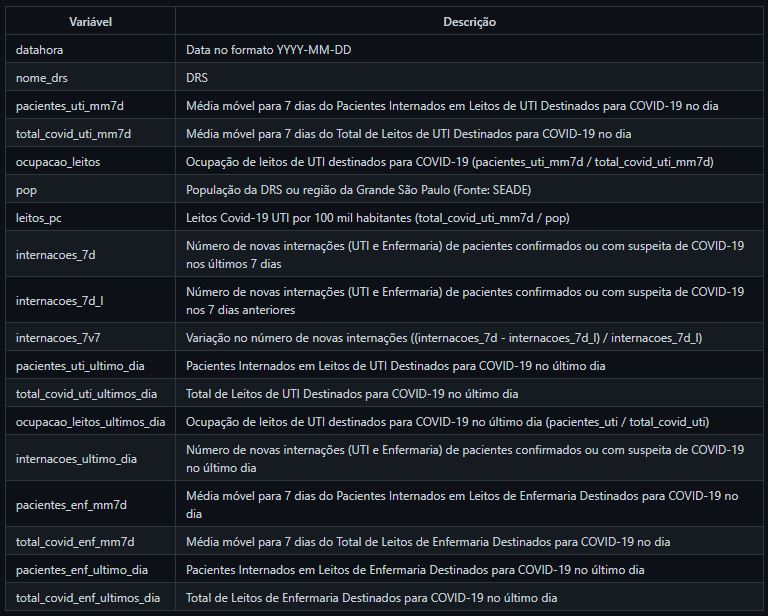

### Loopings de Plots

In [11]:
#_______________creating a code for comparing tree graphs in the same plot______________
def graphcomp2(x,y1,y2,data,title):
    #Setting colors
   # sns.set_palette('Accent')
   # sns.set_style('darkgrid')
    
    #Setting the plot figure 1
    plt.figure(figsize=(16,6))
    ax = plt.subplot(3,1,1)
    ax.set_title(title,fontsize = 18, loc = 'left')
    sns.lineplot(x=x, y=y1, data = data)
    
    #Setting the plot figure II
    ax = plt.subplot(3,1,2)
    sns.lineplot(x=x, y=y2, data = data)

    ax=ax

In [12]:

#Creating a routine to plot the funcion and their diff
def plotacf(y1,y2):#,y3):
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(311)
    fig = plot_acf(y1, ax=ax1, title = 'Observed - ACF')
    ax2 = fig.add_subplot(312)
    fig = plot_acf(y2, ax=ax2, title = 'First Y Diff - ACF' )
#     ax3 = fig.add_subplot(313)
#     fig = plot_acf(y3, ax=ax3, title = 'Second Y Diff - ACF')

def plotpacf(y1,y2):#,y3):
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(311)
    fig = plot_pacf(y1, ax=ax1, title = 'Observed - PACF',lags = [0,1,2,3,4,5,6,7] )
    ax2 = fig.add_subplot(312)
    fig = plot_pacf(y2, ax=ax2, title = 'First Y Diff - PACF',lags = [0,1,2,3,4,5,6,7] )
#     ax3 = fig.add_subplot(313)
#     fig = plot_pacf(y3, ax=ax3, title = 'Second Y Diff - PACF',lags = [1,2,3] )

In [14]:
def previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q=0):

    ######################################################## MODELO COMPLETO #####################################################


    ##################################

    #           Criando Variável PDQ              #

    #################################

    #importing libraries:
    import itertools

    #inputing the range for p, d and q:
    p = d = q = range(0,2)

    #creating a List of possibilities for p,d and q
    pdq = list(itertools.product(p, d, q))


    ################################################

    #          Criação das Variáveis            #

    ###############################################



    ######### Criando o DF filtrado pela regição especificada pelo usuário  ##############

    df_filtrado = df[df[coluna_filtrada] == filtro].reset_index(drop=True)

    ######## Variáveis X, Ys para todo Dataset, para a região filtrada ##########

    y_leitos = df_filtrado.total_covid_uti_ultimo_dia
    y_pacientes = df_filtrado.pacientes_uti_ultimo_dia 
    x = df_filtrado.datahora

    ######## Variáveis X, Ys para todo datas estabelecidas de Treino e Teste pelas datas inputadas pelo user  ##########

    ### Criando y de UTIS diponíveis de treino;

    y_uti_treino = df_filtrado.total_covid_uti_ultimo_dia.loc[
        (df_filtrado.datahora >= data_inicio_treino) & (df_filtrado.datahora <= data_fim_treino)
        ].reset_index(drop=True)

    ### Criando y de pacientes de treino (usado para criar modelo);

    y_pacientes_treino = df_filtrado.pacientes_uti_ultimo_dia.loc[
        (df_filtrado.datahora >= data_inicio_treino) & (df_filtrado.datahora <= data_fim_treino)
        ].reset_index(drop=True)


    ### Criando x de treino;

    x_treino = df_filtrado.datahora.loc[
        (df_filtrado.datahora >= data_inicio_treino) & (df_filtrado.datahora <= data_fim_treino)
        ].reset_index(drop=True)

    ### Criando y de teste (usado para medir a acuracidade do modelo);
    y_pascientes_teste = df_filtrado.pacientes_uti_ultimo_dia.loc[
        (df_filtrado.datahora >= data_fim_treino) & (df_filtrado.datahora <= data_fim_previsao)
        ].reset_index(drop=True)

    ### Criando x de teste;

    x_teste = df_filtrado.datahora.loc[
        (df_filtrado.datahora >= data_fim_treino) & (df_filtrado.datahora <= data_fim_previsao)
        ].reset_index(drop=True)

    ### Criando Constante de número de UTIs congeladas com o ultimo valor de teste;

    cte_uti = y_uti_treino.iloc[-1]

    #criando um vetor do mesmo tamanho do X de teste, com valores do ultimo leito.
    y_leitos_congelados = np.linspace(cte_uti,cte_uti,len(x_teste))


    ################################################

    # Plot 0 - Disponibilidade de Leitos      #

    ###############################################

    ### Criação do Título do Plot
    title = 'Leitos Disponível '+ filtro


    ### INputs de data, e labels###
    #data = df_filtrado

    y_leitos_label = y_leitos.name
    #y_pacientes_label = y_pacientes.name

    xlabel = x.name

    ### Criando parametros do gráfico - matplotlib###

    fig,zx = plt.subplots()
    fig.set_size_inches(15,5)

    zx.set_title(title , fontsize = 20, color = 'gray',loc = 'left')
    zx.grid(color = 'lightgray')
    zx.set_xlabel('Data',fontsize = 15, color = 'gray')
    plt.xticks(rotation = 45,) 
    zx.set_ylabel('Leitos' ,fontsize = 15, color = 'gray')

    ### CRIANDO OS PLOTS

    #plot1
    zx.plot(x, y_leitos , label = 'Leitos Disponíveis UTI - COVID-19', color = 'blue' )

    #plotando Legenda
    plt.legend(fontsize=12)

    zx=zx
    ################################################

    # Plot 1 - Grafico de Leitos Vs Pacientes      #

    ###############################################

    ### Criação do Título do Plot
    title = 'Leitos Disponível vs Utilizados no '+ filtro


    ### INputs de data, e labels###
    #data = df_filtrado

    y_leitos_label = y_leitos.name
    y_pacientes_label = y_pacientes.name

    xlabel = x.name

    ### Criando parametros do gráfico - matplotlib###

    fig,ax = plt.subplots()
    fig.set_size_inches(15,5)

    ax.set_title(title , fontsize = 20, color = 'gray',loc = 'left')
    ax.grid(color = 'lightgray')
    ax.set_xlabel('Data',fontsize = 15, color = 'gray')
    plt.xticks(rotation = 45,) 
    ax.set_ylabel('Leitos' ,fontsize = 15, color = 'gray')

    ### CRIANDO OS PLOTS

    #plot1
    ax.plot(x, y_leitos , label = y_leitos_label, color = 'blue' )

    #plot2
    ax.plot(x, y_pacientes , label = y_pacientes_label,color = 'darkorange' )

    #Plotando datas: Início do treino

    ax.scatter(data_inicio_treino , y_pacientes[df_filtrado.datahora == data_inicio_treino],label = 'data_inicio_treino')

    #Plotando datas: Fim do treino

    ax.scatter(data_fim_treino , y_pacientes[df_filtrado.datahora == data_fim_treino],color = 'red', label = 'data_fim_treino')

    #Plotando datas: Fim da Previsão

    ax.scatter(data_fim_previsao , y_pacientes[df_filtrado.datahora == data_fim_previsao],color = 'black',label = 'data_fim_previsao')

    #plotando Legenda
    plt.legend(fontsize=12)

    ax=ax
    
    ######################################################################

    ##Plot 2 - Grafico de Leitos Vs Pacientes datas de treino e teste   #

    #######################################################################



    ### Criação do Título do Plot
    title = 'Leitos Disponíveis e ocupados utilizado no modelo de '+ filtro


    ### Criando parametros do gráfico - matplotlib###

    fig,bx = plt.subplots()
    fig.set_size_inches(15,5)

    bx.set_title(title , fontsize = 20, color = 'gray',loc = 'left')
    bx.grid(color = 'lightgray')
    bx.set_xlabel('Data',fontsize = 15, color = 'gray')
    plt.xticks(rotation = 45,) 
    bx.set_ylabel('Leitos' ,fontsize = 15, color = 'gray')

    ### CRIANDO OS PLOTS

    #Plotando número de leitos diponíveis no "treino"
    label = 'Utis Disponíveis'
    bx.plot(x_treino , y_uti_treino , label=label, color = 'blue' )

    #Plotando número de leitos diponíveis no "teste"
    label = 'Utis Ocupadas'
    bx.plot(x_treino , y_pacientes_treino , label=label, color = 'darkorange' )

    #Plotando número de leitos diponíveis no "treino"
    label = 'Utis Disponíveis _ projeção'
    bx.plot(x_teste , y_leitos_congelados , label=label, color = 'blue',linestyle = ":"  )

    #Plotando número de leitos ocupados no "treino"
    label = 'Utis Ocupadas _ grupo de teste'
    bx.plot(x_teste , y_pascientes_teste , label=label, color = 'darkorange',linestyle = ":" )




    #plotando Legenda
    plt.legend(fontsize=12)

    ax=ax


    #######################################################################

    #                 Avaliação de Premissas do Modelo                    #

    ########################################################################


    ###########1) Avaliando Estacionariedade do modelo############

    y = y_pacientes_treino#.diff()

    #____Analysins the Pvalue

    adfullertest = adfuller(y.dropna())
    pvalue = adfullertest[1]

    ### if pvalue > 0,05 this series is not stationary
    print(f'')
    print(f'#################### Adfuller test #####################')
    print('for y:')
    print(f'pvalue = ', adfullertest[1])
    if (pvalue>=0.05):
        print('This serie IS NOT stationary')
    else:
        print('This serie IS stationary')

    ### Adfuller para y.diff
    y = y_pacientes_treino.diff()

    #____Analysins the Pvalue

    adfullertest = adfuller(y.dropna())
    pvalue = adfullertest[1]

    ### if pvalue > 0,05 this series is not stationary

    print(f'')
    print('for y.diff:')
    print(f'pvalue = ', adfullertest[1])
    if (pvalue>=0.05):
        print('This serie IS NOT stationary')
    else:
        print('This serie IS stationary')

    print(f'')
    print(f'##########################################################')

    ############2) plotando Autocorrelações do modelo################


    y1 = y_pacientes_treino

    #Creating the differences:
    y2 = y1.diff().dropna()

    #plotting the results ACF

    #plotacf(y1,y2)

    #plt.savefig('Autocorrelation Analysis')


    #plotting the results PACF

    #plotpacf(y1,y2)

    #plt.savefig('Autocorrelation Analysis')


    ############3) Criando modelo ideal#############################

    #definindo Y para modelo
    y = y_pacientes_treino

    #criando lista de AIC para definir melhor modelo
    aic_list = pd.DataFrame(columns = ['pqd','AIC','Log Likelihood'])

    #criando parametros para teste
    for parametros in pdq:
        model = ARIMA(y,order=parametros)
        model_fit = model.fit(disp=5)

        #print(parametros)
        #print(model_fit.aic)

        #now we want to store the results to see the best one in the end       
        #Data Frame
        #actual_aic = pd.DataFrame(data = [(param, param_seasonal, results.aic, results.llf)], columns=aic_list_df.columns);
        aic_atual = pd.DataFrame(data = [(parametros,model_fit.aic,model_fit.llf)], columns = aic_list.columns) 
        #consolidating DF
        aic_list = aic_list.append(aic_atual,ignore_index=True)
    #classificando melhores AICs
    aic_list.sort_values(by=['AIC'],inplace=True,ignore_index=True)

    #printando Lista
    print(aic_list)

    ## ROdando o modelo com o melhor parametro:

    #creating the ARIMA model:

    model = ARIMA(y,order= aic_list.pqd[0+q_desloq])
    model_fit = model.fit(disp=5)
    print('')
    print('')
    print(model_fit.summary())

    ############5) Fazendo predição#################################

    #Previsão
    x_teste
    y_pacientes_previsao = pd.DataFrame(model_fit.forecast(len(x_teste))[0],columns =['Forcast'])

    #Intervalo de confiaça
    y_ci = pd.DataFrame(model_fit.forecast(len(x_teste))[2],columns =['Lower', 'Upper'])


    ############6) plotando accuracidade############################

    y_true = y_pascientes_teste
    y_pred = y_pacientes_previsao


    #MAE (absolute error) MAE: The easiest to understand. Represents average error

    mae = metrics.mean_absolute_error(y_true, y_pred)


    # #MSE MSE: Similar to MAE but noise is exaggerated and larger errors are “punished”. 
    # It is harder to interpret than MAE as it’s not in base units, however, it is generally more popular.

    mse = metrics.mean_squared_error(y_true, y_pred, squared = True )


    #  RMSE RMSE: Most popular metric, similar to MSE, however, the result 
    # is square rooted to make it more interpretable as it’s in base units. 
    # It is recommended that RMSE be used as the primary metric to interpret your model.

    rmse = metrics.mean_squared_error(y_true, y_pred, squared = False)



    print(f'o MAE, ou erro absoluto médio do modelo é: ', mae )
    print(f'o RMSE : ', rmse )

    ###############################################################################

    # Plot 3- Grafico de Leitos Vs Pacientes datas de treino e teste e modelo ##

    ###############################################################################



    ### Criação do Título do Plot
    title = 'Leitos Disponíveis, Ocupação e Previsão do modelo para '+ filtro


    ### Criando parametros do gráfico - matplotlib###

    fig,cx = plt.subplots()
    fig.set_size_inches(15,5)

    cx.set_title(title , fontsize = 20, color = 'gray',loc = 'left')
    cx.grid(color = 'lightgray')
    cx.set_xlabel('Data',fontsize = 15, color = 'gray')
    plt.xticks(rotation = 45,) 
    cx.set_ylabel('Leitos' ,fontsize = 15, color = 'gray')

    ### CRIANDO OS PLOTS

    #Plotando número de leitos diponíveis no "treino"
    label = 'Utis Disponíveis'
    cx.plot(x_treino , y_uti_treino , label=label, color = 'blue' )

    #Plotando número de leitos diponíveis no "teste"
    label = 'Utis Ocupadas'
    cx.plot(x_treino , y_pacientes_treino , label=label, color = 'darkorange' )

    #Plotando número de leitos diponíveis no "treino"
    label = 'Utis Disponíveis _ projeção'
    cx.plot(x_teste , y_leitos_congelados , label=label, color = 'blue',linestyle = ":"  )

    #Plotando número de leitos ocupados no "treino"
    label = 'Utis Ocupadas _ grupo de teste'
    cx.plot(x_teste , y_pascientes_teste , label=label, color = 'darkorange',linestyle = ":" )

    #Protando Previsão do modelo

    cx.plot(x_teste, y_pacientes_previsao , label = 'Previsão Modelo', linestyle = None , color = 'gray')

    #Plotando intervalo de confiaça

    cx.fill_between(x_teste , y_ci.Lower, y_ci.Upper ,color='k',alpha=0.05)

    #plotando Legenda
    plt.legend(fontsize=10,loc = 'upper left')

    cx=cx
    
    ###############################################################################

    # Análise de Resíduos ##

    ###############################################################################
    
    residuals = pd.DataFrame(model_fit.resid , columns = ['Observações resíduos'])
    
    residuals.plot(title = "Resíduos",figsize = [13,3],grid = True)
    residuals.plot(kind='kde', title = "Resíduos",figsize = [12,3],grid = True)
    plt.show()
    print('###### Estatística descritiva dos Resíduos ############')
    print(residuals.describe())
    
    stat, p = shapiro( residuals)

    print('Teste de Shapiro para validação de Normalidade dos Resíduos \nstat=%.3f , p=%.3f\n' % (stat,p))

    if p >= 0.05:
        print('Resíduos passaram no teste de Normalidade')
    else:
        print ('Resíduos não passaram no teste de Normalidade')


    

Grande SP Leste

#################### Adfuller test #####################
for y:
pvalue =  0.01436075959544084
This serie IS stationary

for y.diff:
pvalue =  1.6043807352633304e-10
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (0, 1, 1)  295.911898     -144.955949
1  (1, 1, 1)  296.951226     -144.475613
2  (1, 1, 0)  301.841504     -147.920752
3  (1, 0, 1)  304.657025     -148.328513
4  (1, 0, 0)  305.085343     -149.542671
5  (0, 1, 0)  305.172467     -150.586234
6  (0, 0, 1)  307.273579     -150.636790
7  (0, 0, 0)  315.779359     -155.889680


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   37
Model:                         ARIMA(0, 1, 1)   Log Likelihood                -144.956
Method:                               css-mle   S.D. of innovations             12.079
Date:         

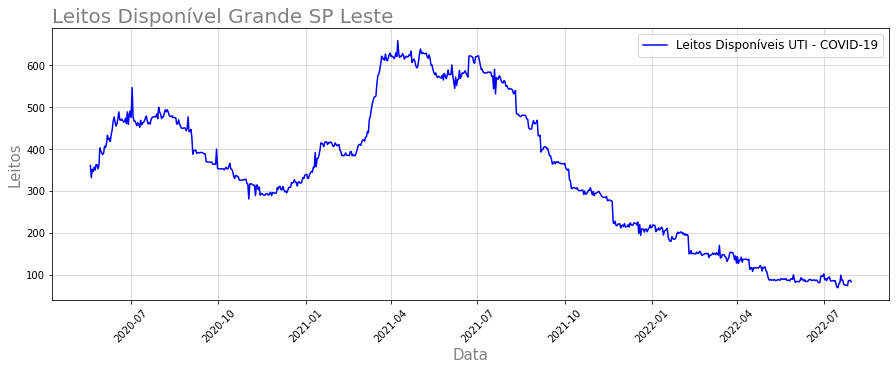

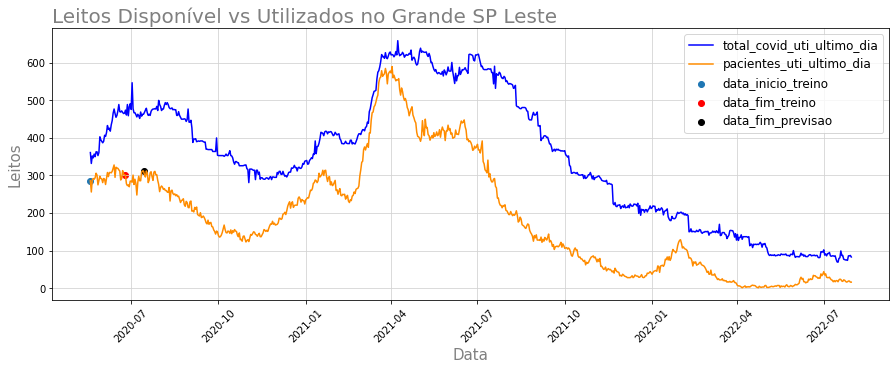

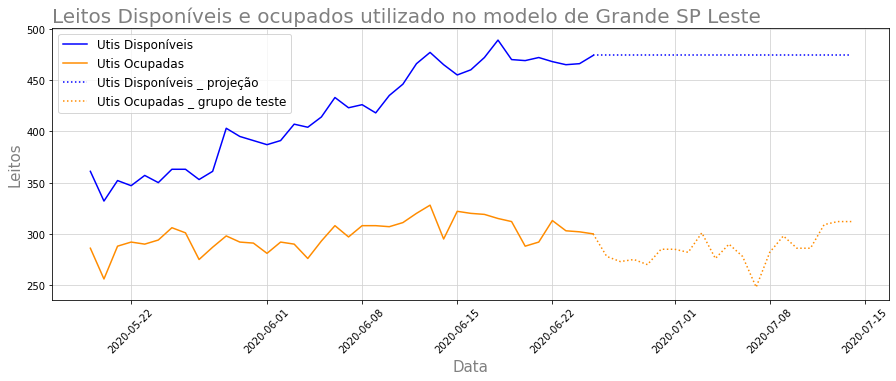

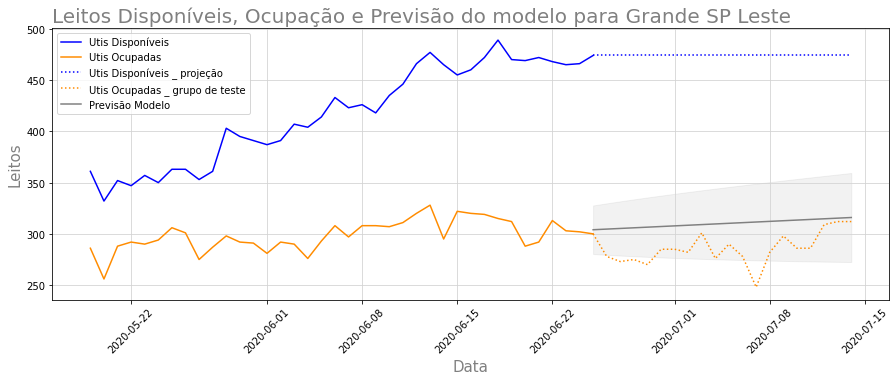

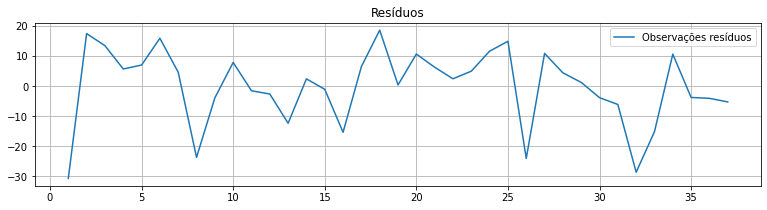

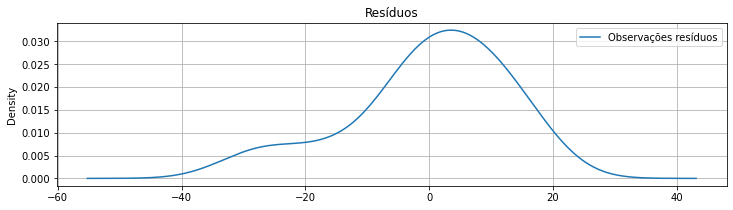

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             37.000000
mean              -0.131371
std               12.602738
min              -30.627690
25%               -4.073973
50%                2.389144
75%                7.829595
max               18.548210
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.931 , p=0.025

Resíduos não passaram no teste de Normalidade


In [15]:
 ######### Inputs de Data Set ################

df = leitos_internacao
filtro = df.nome_drs[1]
coluna_filtrada = 'nome_drs'

print(df.nome_drs[1])

##### Inputs de datas do Modelo #############

coluna_data = 'datahora' #coluna no data set que contem a data

data_inicio_treino = ' 2020-05-19' #Data de início de treino do modelo
data_fim_treino = '2020-06-25' #data de Fim de treino do modelo
data_fim_previsao = '2020-07-14' #Data de fim de previsão

q_desloq=0


previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)

Grande SP Leste

#################### Adfuller test #####################
for y:
pvalue =  0.06577941698419985
This serie IS NOT stationary

for y.diff:
pvalue =  1.5301021506233295e-15
This serie IS stationary

##########################################################


C:\Apps\Anaconda3\v3_8_5_x64\Local\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         pqd         AIC  Log Likelihood
0  (1, 1, 0)  414.048660     -204.024330
1  (0, 1, 1)  414.523928     -204.261964
2  (0, 1, 0)  419.355172     -207.677586
3  (1, 1, 1)  423.366536     -207.683268
4  (1, 0, 1)  427.836004     -209.918002
5  (1, 0, 0)  429.828756     -211.914378
6  (0, 0, 1)  447.622386     -220.811193
7  (0, 0, 0)  459.723292     -227.861646


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   37
Model:                         ARIMA(1, 1, 0)   Log Likelihood                -204.024
Method:                               css-mle   S.D. of innovations             59.897
Date:                        Mon, 26 Sep 2022   AIC                            414.049
Time:                                11:04:22   BIC                            418.881
Sample:                                     1   HQIC                           415.752
                    

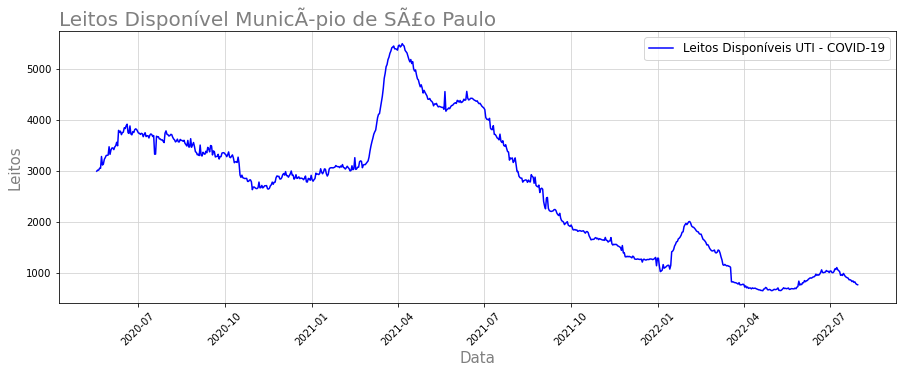

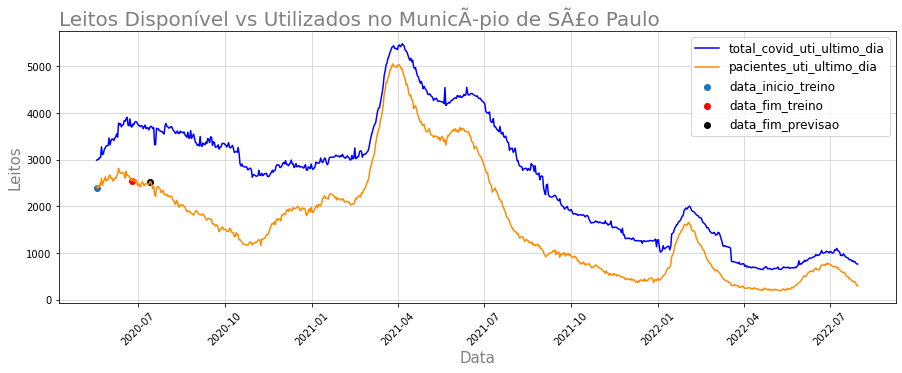

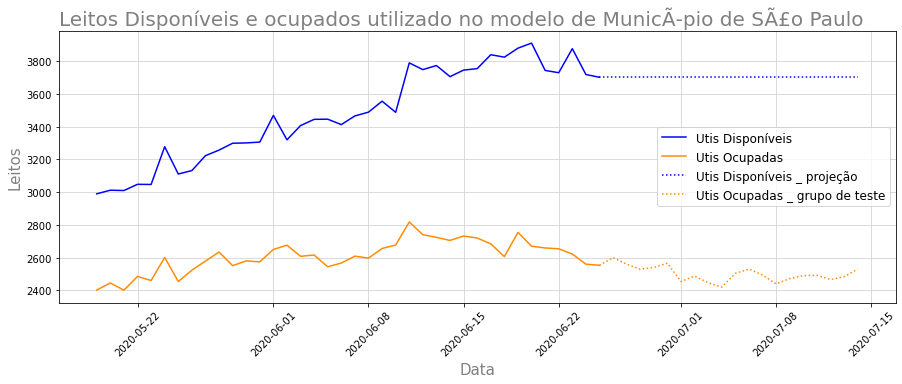

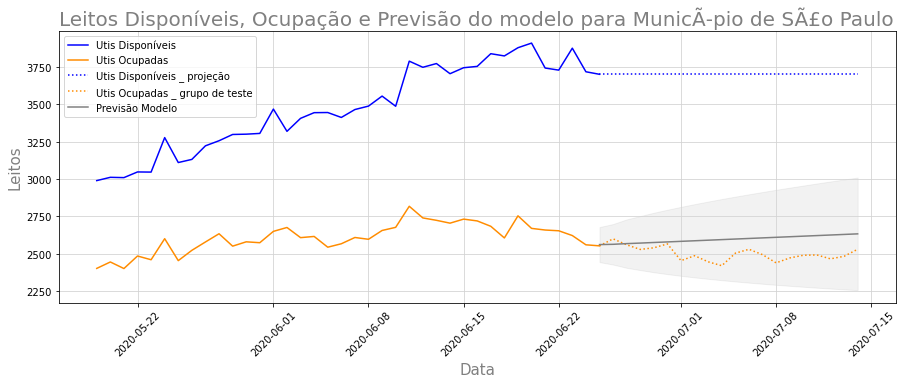

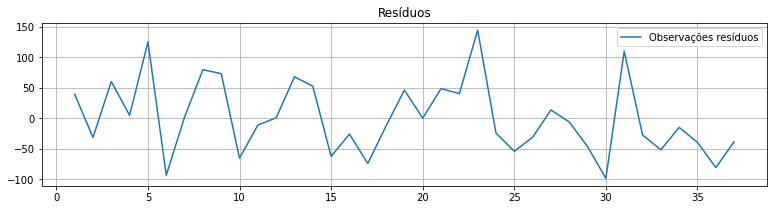

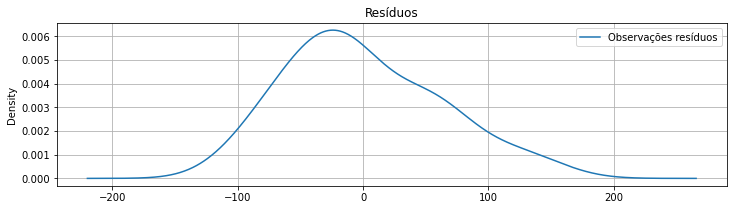

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             37.000000
mean               0.443599
std               60.782688
min              -98.568506
25%              -39.568662
50%              -11.277946
75%               46.173132
max              144.334432
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.965 , p=0.287

Resíduos passaram no teste de Normalidade


In [16]:
 ######### Inputs de Data Set ################

df = leitos_internacao
filtro = df.nome_drs[0]
coluna_filtrada = 'nome_drs'

print(df.nome_drs[1])

##### Inputs de datas do Modelo #############

coluna_data = 'datahora' #coluna no data set que contem a data

data_inicio_treino = ' 2020-05-19' #Data de início de treino do modelo
data_fim_treino = '2020-06-25' #data de Fim de treino do modelo
data_fim_previsao = '2020-07-14' #Data de fim de previsão

q_desloq=0


previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)


#################### Adfuller test #####################
for y:
pvalue =  0.28275198126289564
This serie IS NOT stationary

for y.diff:
pvalue =  6.466994432922339e-12
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (1, 1, 1)  287.281658     -139.640829
1  (0, 1, 1)  288.659790     -141.329895
2  (1, 1, 0)  289.541641     -141.770821
3  (0, 1, 0)  290.442324     -143.221162
4  (1, 0, 0)  295.978355     -144.989177
5  (1, 0, 1)  297.241334     -144.620667
6  (0, 0, 1)  308.103887     -151.051943
7  (0, 0, 0)  322.366454     -159.183227


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   37
Model:                         ARIMA(1, 1, 1)   Log Likelihood                -139.641
Method:                               css-mle   S.D. of innovations             10.192
Date:                      

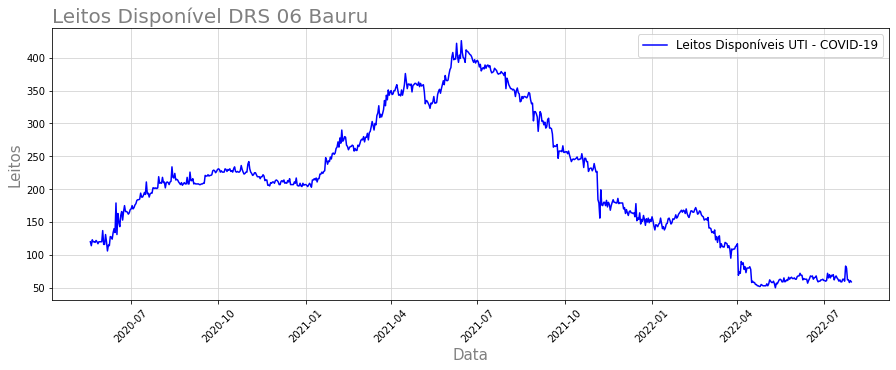

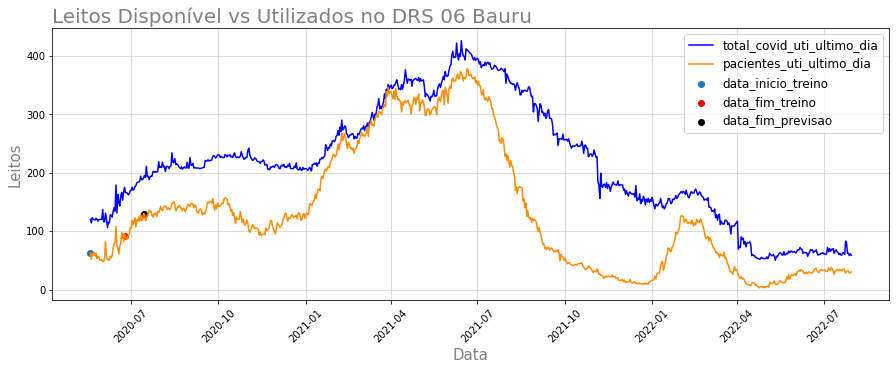

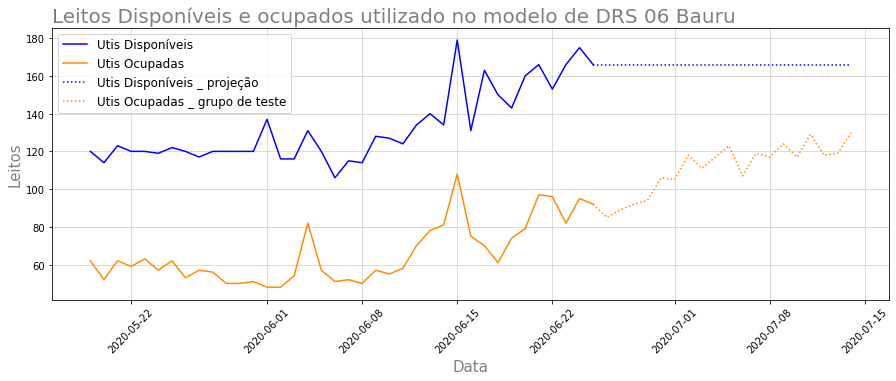

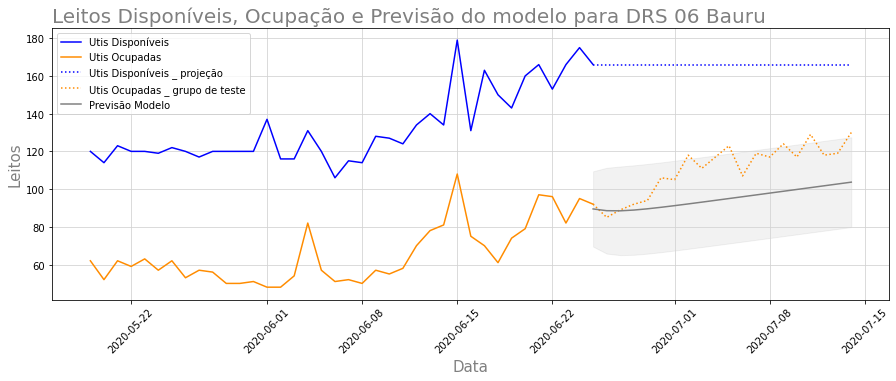

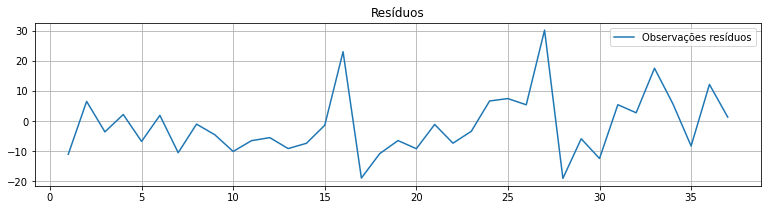

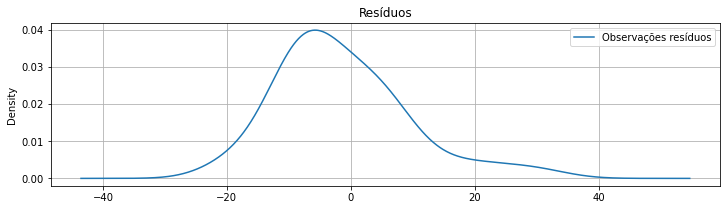

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             37.000000
mean              -1.384412
std               10.508448
min              -18.978053
25%               -8.245894
50%               -3.561072
75%                5.407688
max               30.150427
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.931 , p=0.025

Resíduos não passaram no teste de Normalidade


In [17]:
filtro = df.nome_drs[10]
q_desloq=0
previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)


#################### Adfuller test #####################
for y:
pvalue =  0.997079274427489
This serie IS NOT stationary

for y.diff:
pvalue =  7.42753585966237e-13
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (0, 1, 1)  239.650807     -116.825404
1  (1, 1, 1)  241.493853     -116.746926
2  (1, 1, 0)  242.039430     -118.019715
3  (0, 1, 0)  244.132975     -120.066488
4  (1, 0, 0)  261.204369     -127.602185
5  (1, 0, 1)  262.562942     -127.281471
6  (0, 0, 1)  323.568770     -158.784385
7  (0, 0, 0)  356.630914     -176.315457


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   37
Model:                         ARIMA(1, 1, 1)   Log Likelihood                -116.747
Method:                               css-mle   S.D. of innovations              5.657
Date:                        M

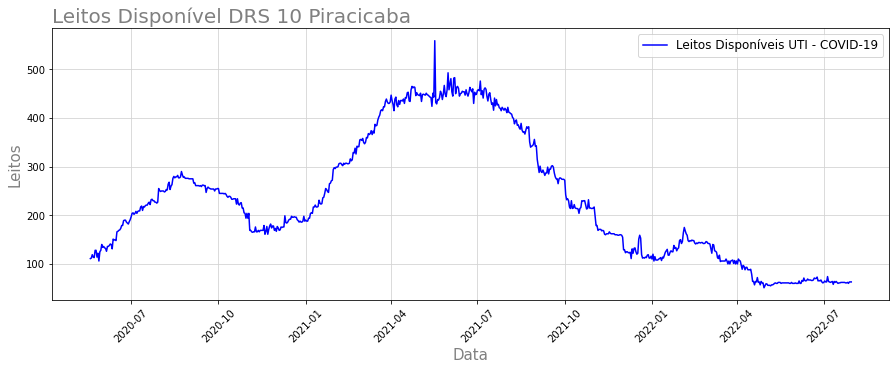

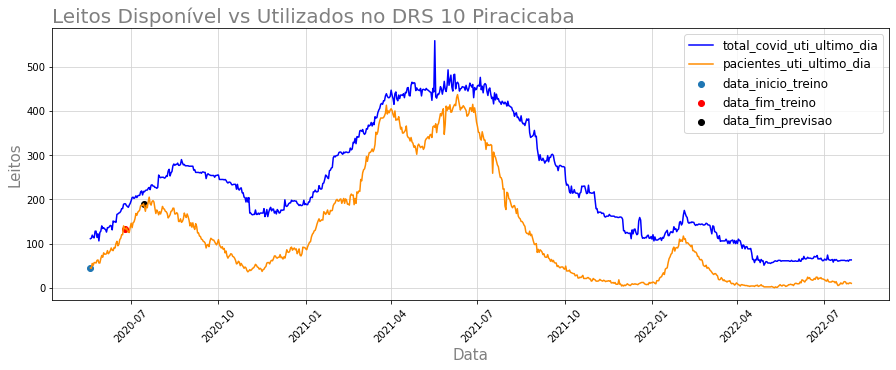

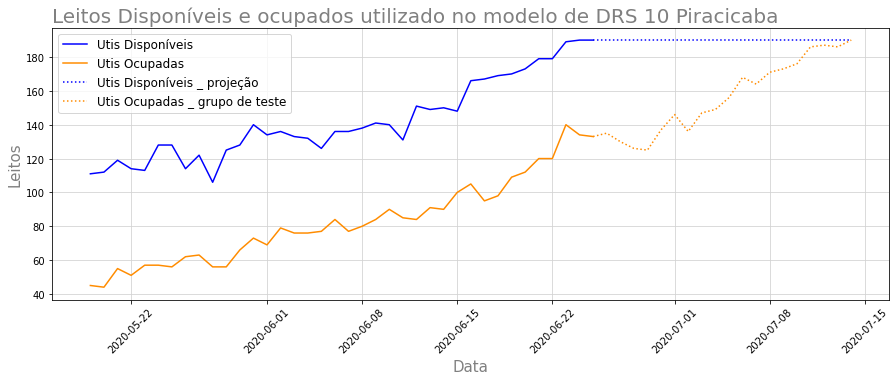

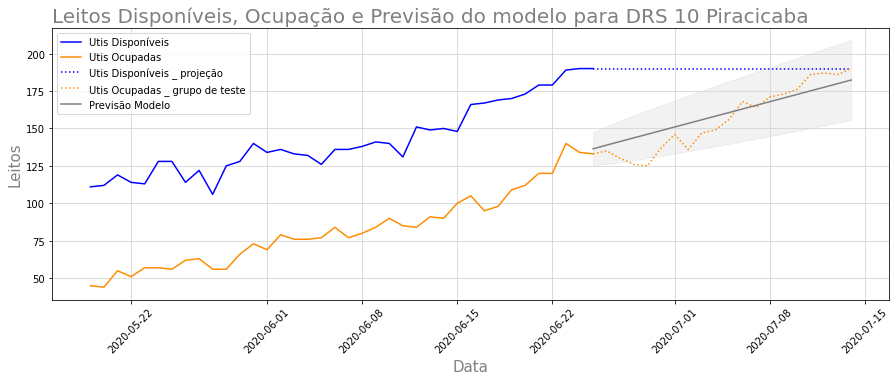

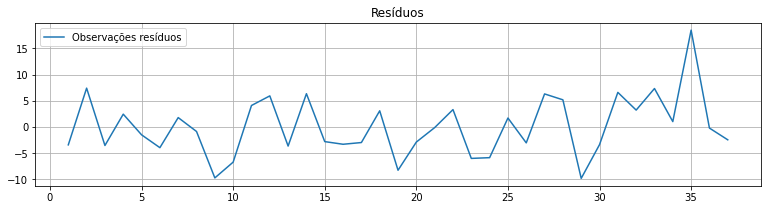

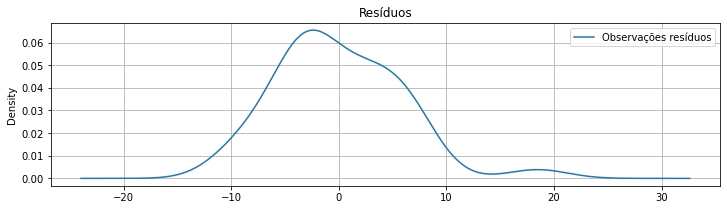

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             37.000000
mean              -0.002448
std                5.747274
min               -9.810173
25%               -3.413141
50%               -0.861052
75%                3.315013
max               18.477313
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.947 , p=0.076

Resíduos passaram no teste de Normalidade


In [18]:
filtro = df.nome_drs[14]
q_desloq=1
previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)


#################### Adfuller test #####################
for y:
pvalue =  0.9952717078989932
This serie IS NOT stationary

for y.diff:
pvalue =  0.0012133881261688177
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (0, 1, 1)  160.610257      -77.305128
1  (1, 1, 1)  161.273540      -76.636770
2  (1, 1, 0)  161.281696      -77.640848
3  (0, 1, 0)  162.267793      -79.133897
4  (1, 0, 0)  169.813124      -81.906562
5  (1, 0, 1)  170.253325      -81.126662
6  (0, 0, 1)  194.848527      -94.424264
7  (0, 0, 0)  227.230496     -111.615248


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   37
Model:                         ARIMA(0, 1, 1)   Log Likelihood                 -77.305
Method:                               css-mle   S.D. of innovations              1.952
Date:                       

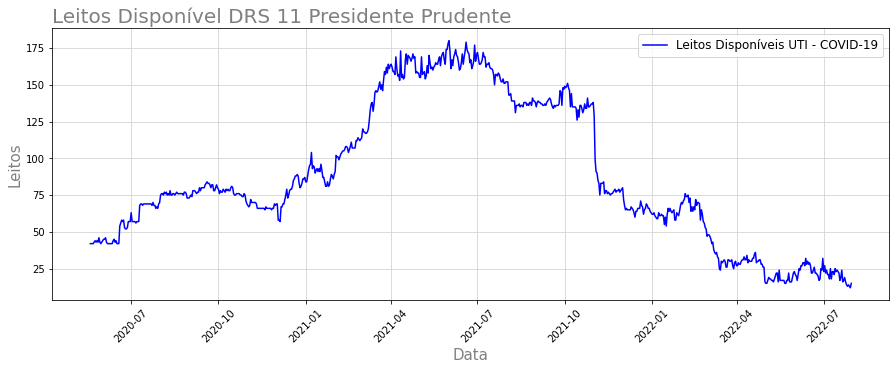

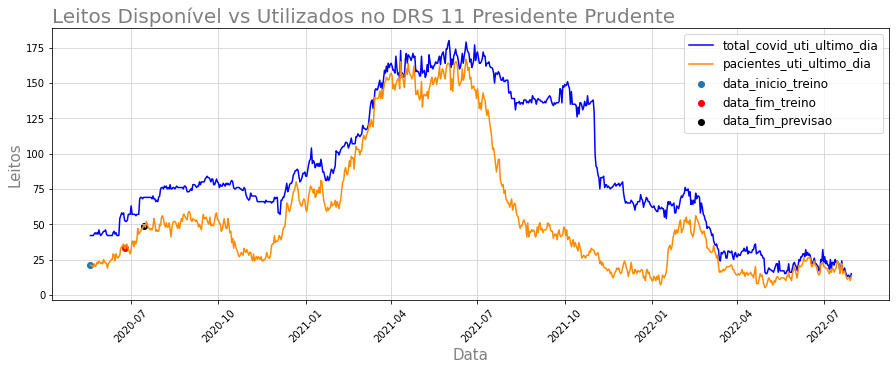

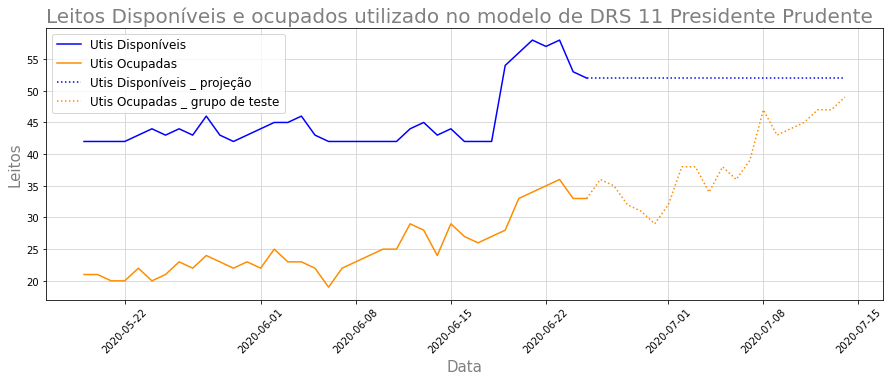

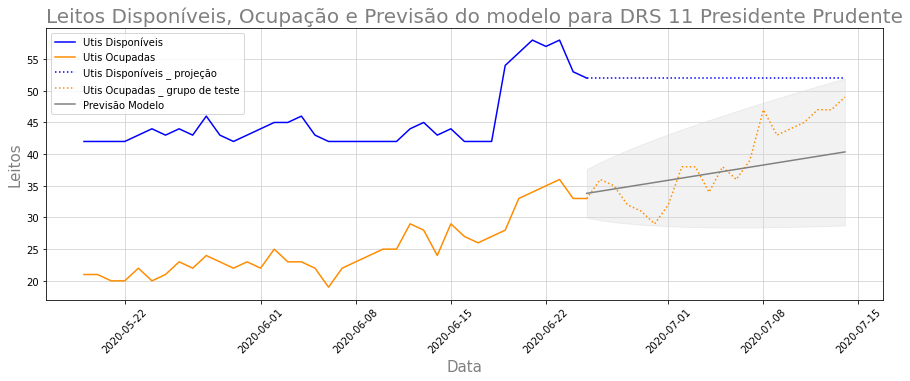

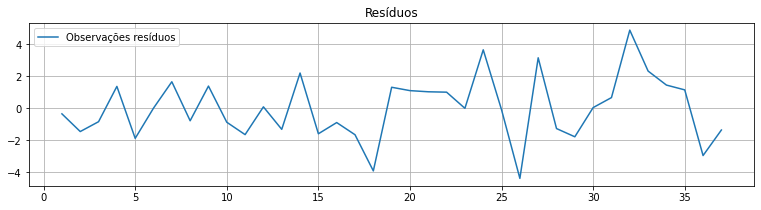

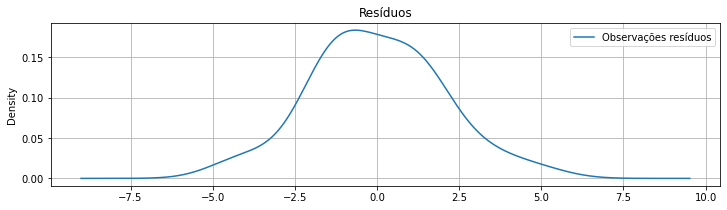

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             37.000000
mean              -0.010568
std                1.978874
min               -4.375912
25%               -1.354306
50%                0.001554
75%                1.317131
max                4.885756
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.982 , p=0.801

Resíduos passaram no teste de Normalidade


In [19]:
filtro = df.nome_drs[15]
q_desloq=0
previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)

Grande SP Leste

#################### Adfuller test #####################
for y:
pvalue =  0.8474168426343573
This serie IS NOT stationary

for y.diff:
pvalue =  2.304606836152676e-12
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (0, 1, 0)  337.376467     -166.688233
1  (1, 1, 0)  339.140364     -166.570182
2  (0, 1, 1)  339.152121     -166.576060
3  (1, 1, 1)  340.984778     -166.492389
4  (1, 0, 0)  348.897059     -171.448530
5  (1, 0, 1)  350.890816     -171.445408
6  (0, 0, 1)  438.041728     -216.020864
7  (0, 0, 0)  493.312419     -244.656210


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   59
Model:                         ARIMA(0, 1, 1)   Log Likelihood                -166.576
Method:                               css-mle   S.D. of innovations              4.073
Date:       

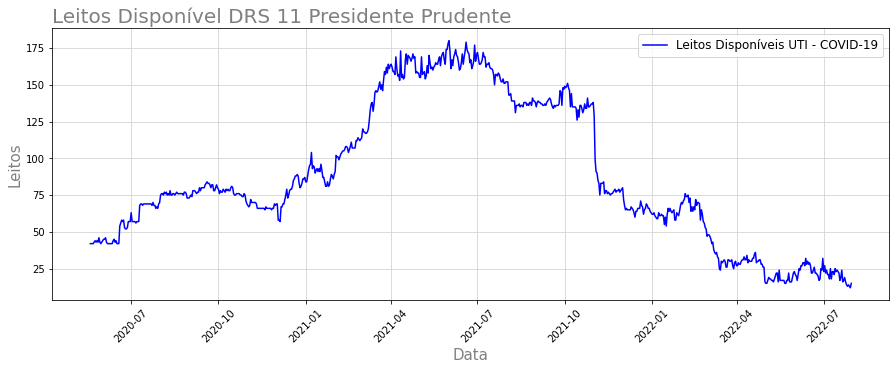

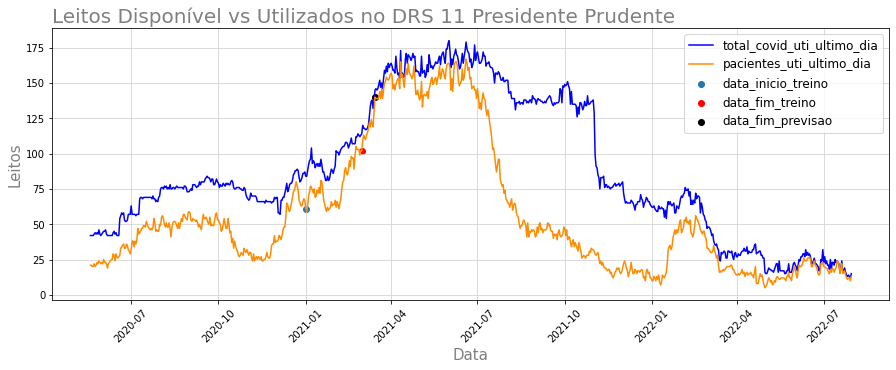

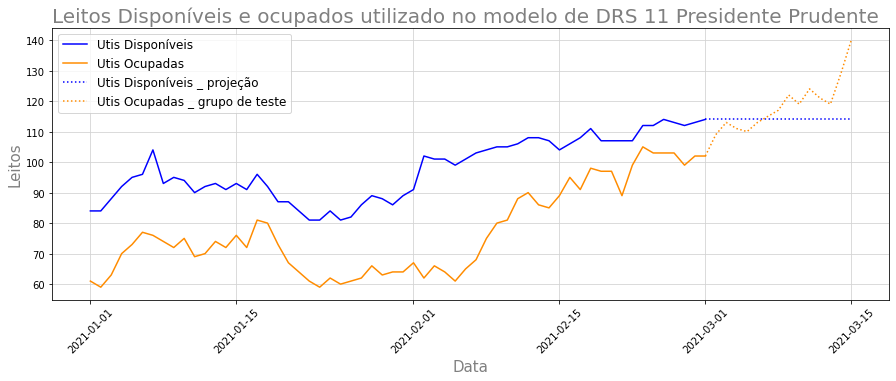

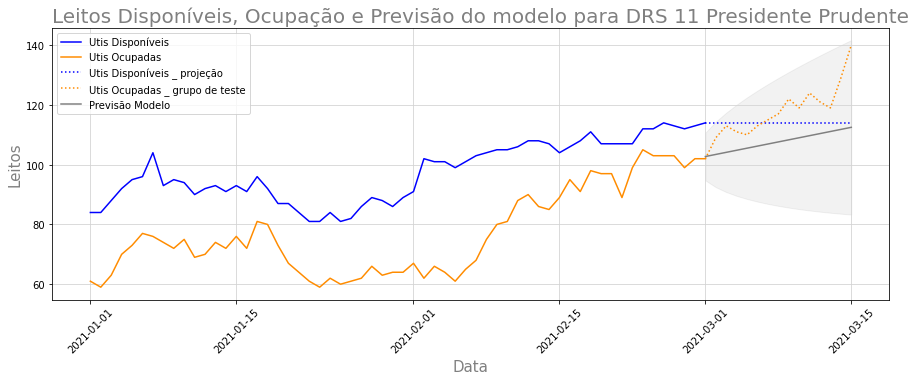

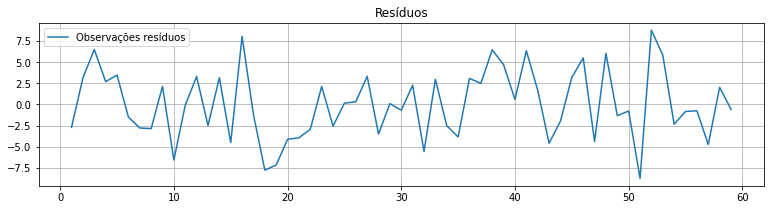

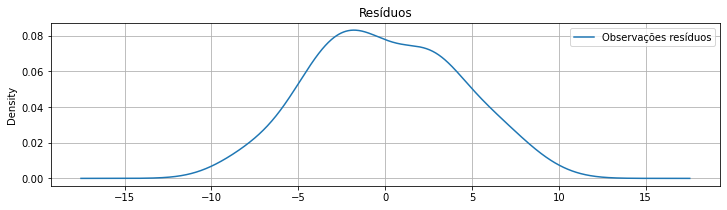

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             59.000000
mean              -0.002660
std                4.107910
min               -8.744529
25%               -2.825918
50%               -0.577319
75%                3.106542
max                8.779101
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.984 , p=0.612

Resíduos passaram no teste de Normalidade


In [20]:
 ######### Inputs de Data Set ################

df = leitos_internacao
filtro = df.nome_drs[15]
coluna_filtrada = 'nome_drs'

print(df.nome_drs[1])

##### Inputs de datas do Modelo #############

coluna_data = 'datahora' #coluna no data set que contem a data

data_inicio_treino = ' 2021-01-01' #Data de início de treino do modelo
data_fim_treino = '2021-03-01' #data de Fim de treino do modelo
data_fim_previsao = '2021-03-15' #Data de fim de previsão

q_desloq=2


previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)

DRS 13 RibeirÃ£o Preto

#################### Adfuller test #####################
for y:
pvalue =  0.16222053826132649
This serie IS NOT stationary

for y.diff:
pvalue =  1.4937071768696428e-15
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (1, 1, 0)  400.577816     -197.288908
1  (0, 1, 0)  400.797358     -198.398679
2  (0, 1, 1)  400.969522     -197.484761
3  (1, 1, 1)  402.352396     -197.176198
4  (1, 0, 0)  420.705138     -207.352569
5  (1, 0, 1)  422.634394     -207.317197
6  (0, 0, 1)  559.667990     -276.833995
7  (0, 0, 0)  619.299414     -307.649707


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   59
Model:                         ARIMA(0, 1, 1)   Log Likelihood                -197.485
Method:                               css-mle   S.D. of innovations              6.876
Dat

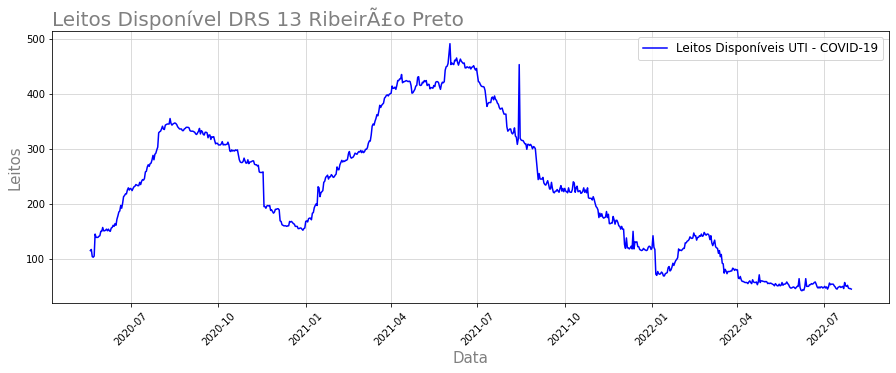

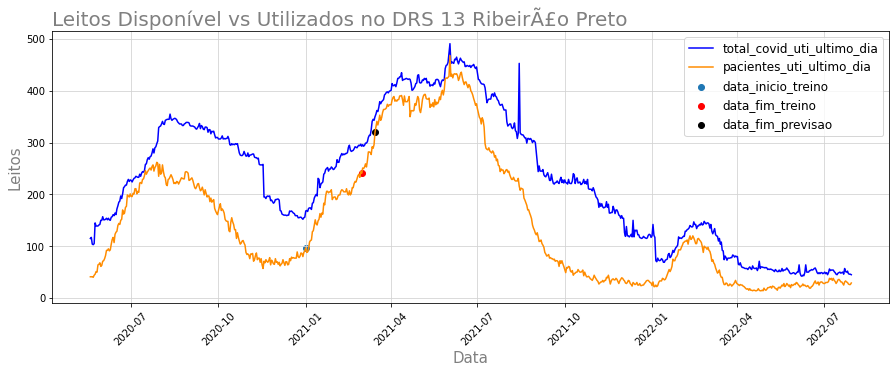

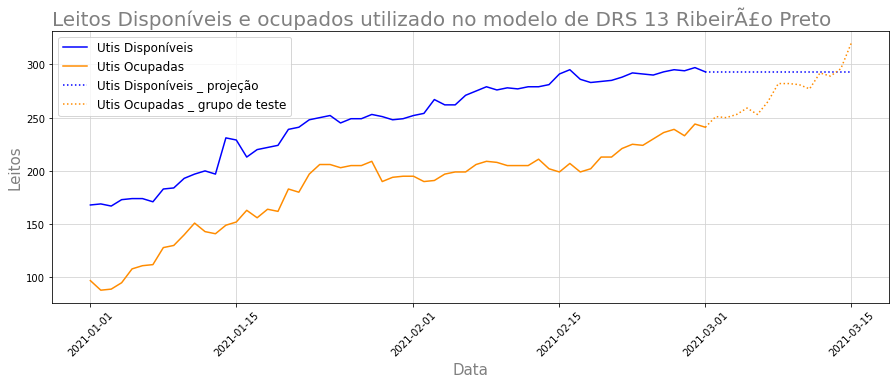

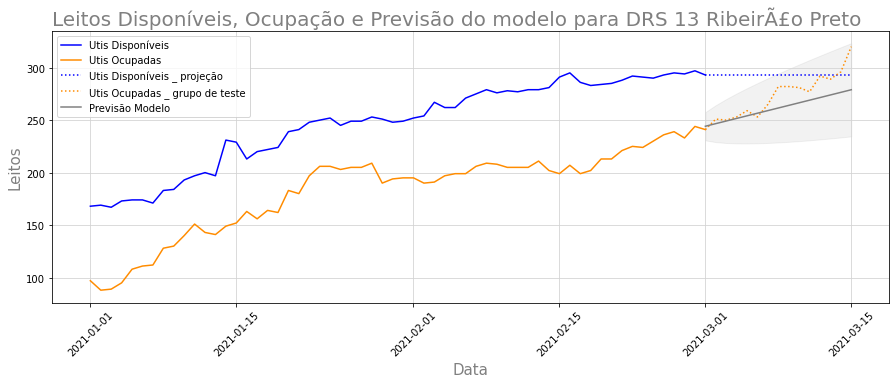

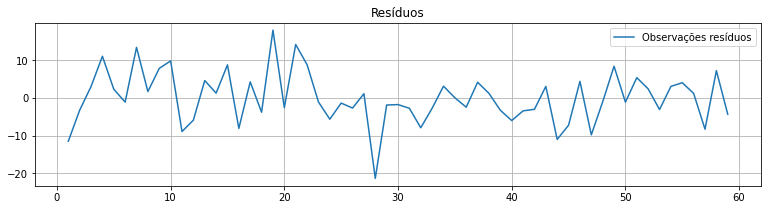

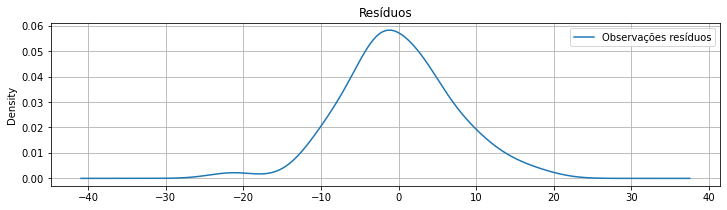

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             59.000000
mean              -0.036548
std                6.939060
min              -21.310471
25%               -3.371448
50%               -1.077515
75%                4.059037
max               17.905843
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.983 , p=0.598

Resíduos passaram no teste de Normalidade


In [21]:
 ######### Inputs de Data Set ################

df = leitos_internacao
filtro = df.nome_drs[17]
coluna_filtrada = 'nome_drs'

print(filtro)

##### Inputs de datas do Modelo #############

coluna_data = 'datahora' #coluna no data set que contem a data

data_inicio_treino = ' 2021-01-01' #Data de início de treino do modelo
data_fim_treino = '2021-03-01' #data de Fim de treino do modelo
data_fim_previsao = '2021-03-15' #Data de fim de previsão

q_desloq=2


previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)

DRS 10 Piracicaba

#################### Adfuller test #####################
for y:
pvalue =  0.5248417621585191
This serie IS NOT stationary

for y.diff:
pvalue =  1.1681037652491898e-18
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (1, 1, 0)  417.404804     -205.702402
1  (0, 1, 1)  417.947332     -205.973666
2  (1, 1, 1)  419.211114     -205.605557
3  (0, 1, 0)  421.924774     -208.962387
4  (1, 0, 0)  440.562436     -217.281218
5  (1, 0, 1)  440.883248     -216.441624
6  (0, 0, 1)  554.017556     -274.008778
7  (0, 0, 0)  610.975855     -303.487927


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   59
Model:                         ARIMA(0, 1, 1)   Log Likelihood                -205.974
Method:                               css-mle   S.D. of innovations              7.935
Date:    

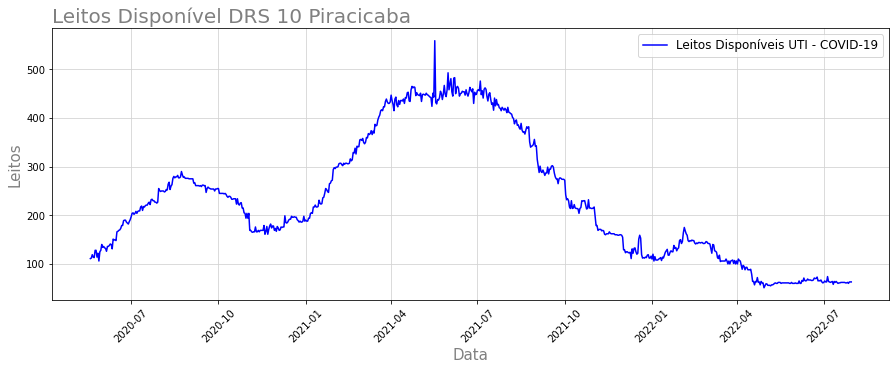

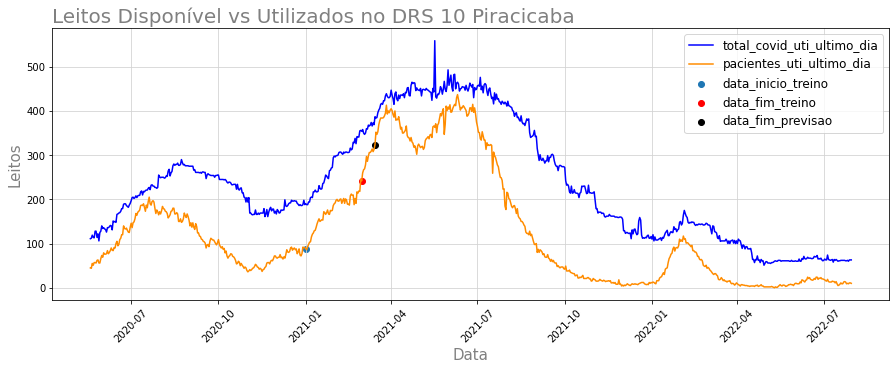

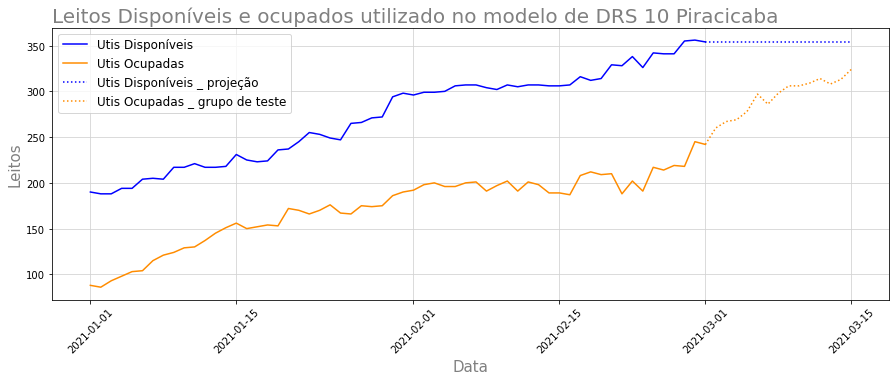

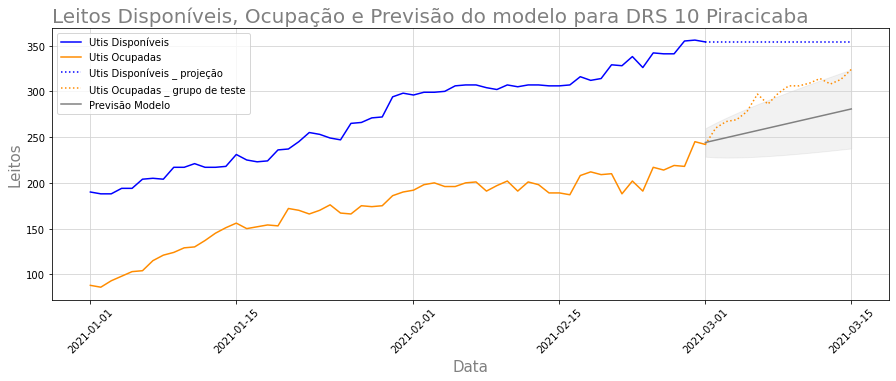

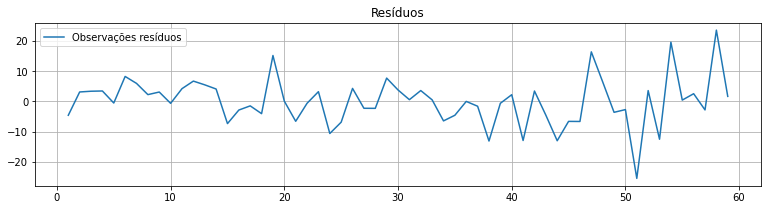

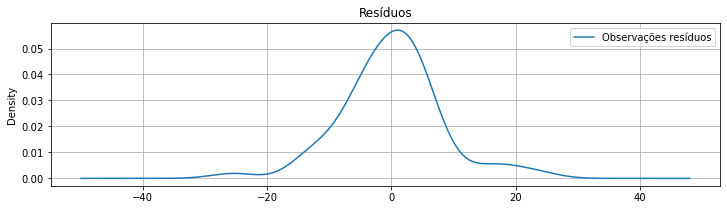

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             59.000000
mean              -0.019527
std                8.005264
min              -25.461314
25%               -4.326512
50%                0.044702
75%                3.541809
max               23.506088
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.950 , p=0.017

Resíduos não passaram no teste de Normalidade


In [22]:
 ######### Inputs de Data Set ################

df = leitos_internacao
filtro = df.nome_drs[14]
coluna_filtrada = 'nome_drs'

print(filtro)

##### Inputs de datas do Modelo #############

coluna_data = 'datahora' #coluna no data set que contem a data

data_inicio_treino = ' 2021-01-01' #Data de início de treino do modelo
data_fim_treino = '2021-03-01' #data de Fim de treino do modelo
data_fim_previsao = '2021-03-15' #Data de fim de previsão

q_desloq=1


previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)

DRS 09 MarÃ­lia

#################### Adfuller test #####################
for y:
pvalue =  0.2202135957451496
This serie IS NOT stationary

for y.diff:
pvalue =  1.179590968413508e-13
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (0, 1, 0)  337.875113     -166.937556
1  (1, 1, 0)  339.019144     -166.509572
2  (0, 1, 1)  339.099401     -166.549701
3  (1, 1, 1)  340.881227     -166.440614
4  (1, 0, 0)  352.754601     -173.377301
5  (1, 0, 1)  354.641729     -173.320864
6  (0, 0, 1)  443.722344     -218.861172
7  (0, 0, 0)  494.982773     -245.491386


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   59
Model:                         ARIMA(1, 1, 0)   Log Likelihood                -166.510
Method:                               css-mle   S.D. of innovations              4.068
Date:       

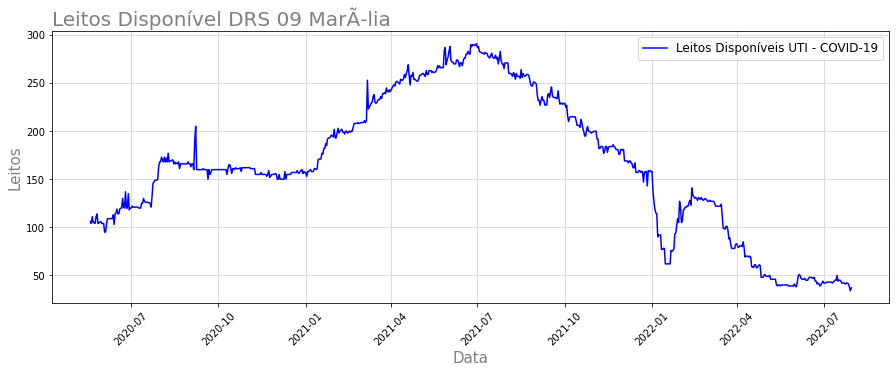

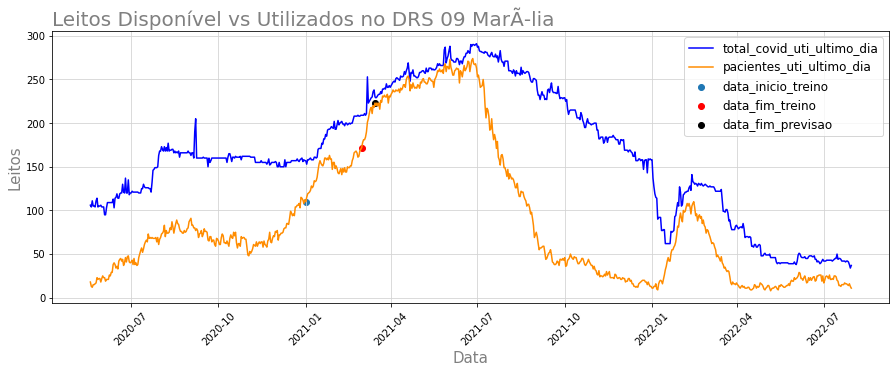

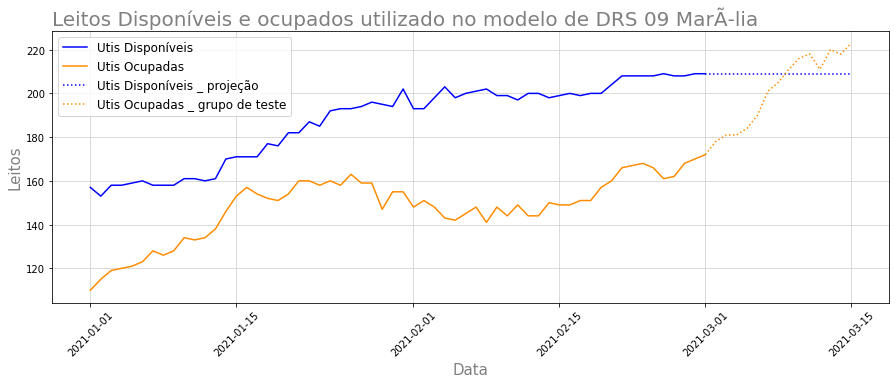

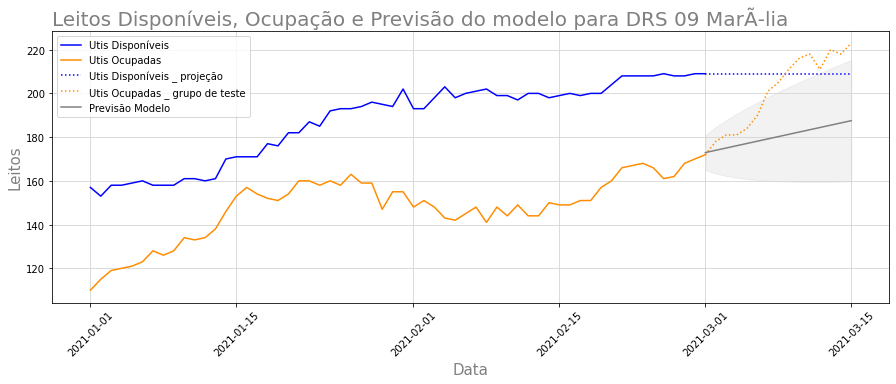

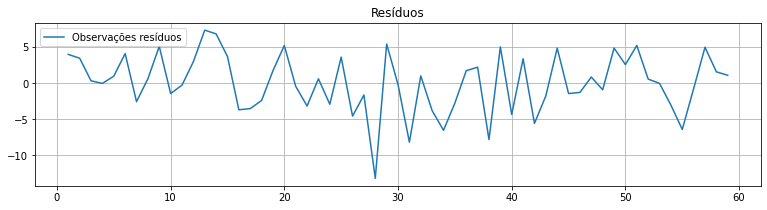

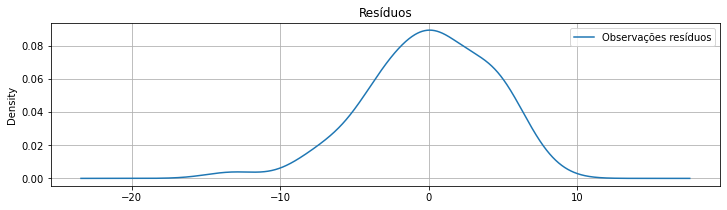

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             59.000000
mean               0.008051
std                4.103316
min              -13.166963
25%               -2.666963
50%                0.313089
75%                3.393043
max                7.313089
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.970 , p=0.151

Resíduos passaram no teste de Normalidade


In [26]:
 ######### Inputs de Data Set ################

df = leitos_internacao
filtro = df.nome_drs[13]
coluna_filtrada = 'nome_drs'

print(filtro)

##### Inputs de datas do Modelo #############

coluna_data = 'datahora' #coluna no data set que contem a data

data_inicio_treino = ' 2021-01-01' #Data de início de treino do modelo
data_fim_treino = '2021-03-01' #data de Fim de treino do modelo
data_fim_previsao = '2021-03-15' #Data de fim de previsão

q_desloq=1


previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)

DRS 08 Franca

#################### Adfuller test #####################
for y:
pvalue =  0.01871584414869446
This serie IS stationary

for y.diff:
pvalue =  0.0016153195969724424
This serie IS stationary

##########################################################
         pqd         AIC  Log Likelihood
0  (0, 1, 0)  354.656794     -175.328397
1  (0, 1, 1)  356.067322     -175.033661
2  (1, 1, 0)  356.374021     -175.187010
3  (1, 1, 1)  357.592033     -174.796017
4  (1, 0, 0)  367.875235     -180.937618
5  (1, 0, 1)  369.812370     -180.906185
6  (0, 0, 1)  456.581339     -225.290670
7  (0, 0, 0)  519.711176     -257.855588


                                 ARIMA Model Results                                  
Dep. Variable:     D.pacientes_uti_ultimo_dia   No. Observations:                   59
Model:                         ARIMA(0, 1, 1)   Log Likelihood                -175.034
Method:                               css-mle   S.D. of innovations              4.700
Date:            

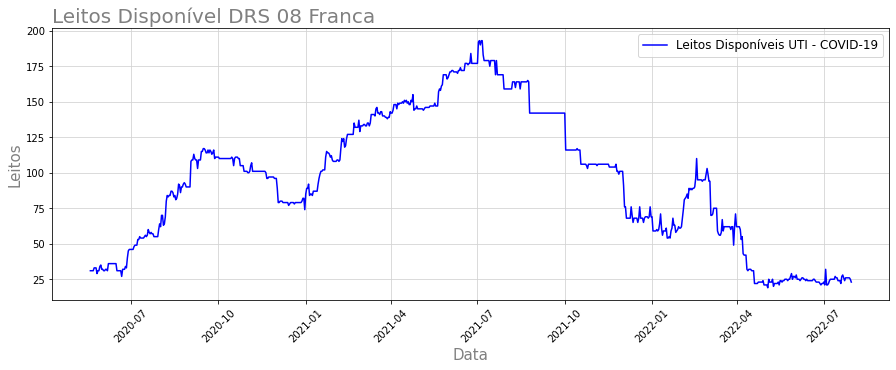

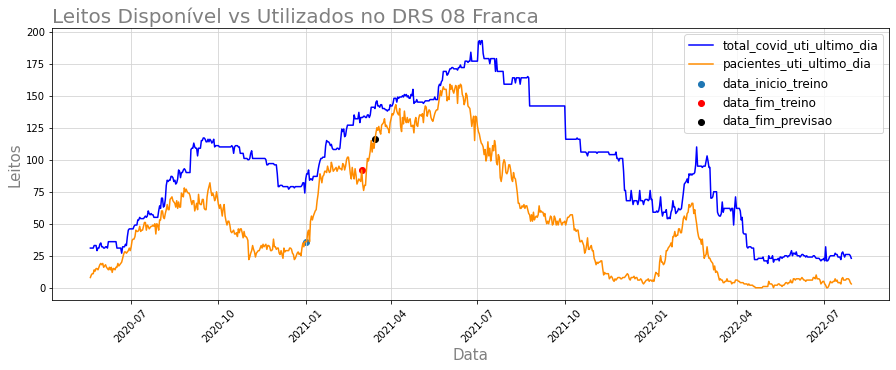

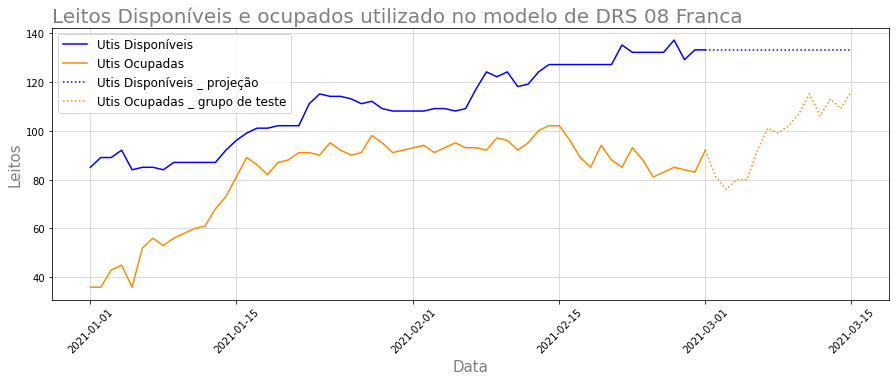

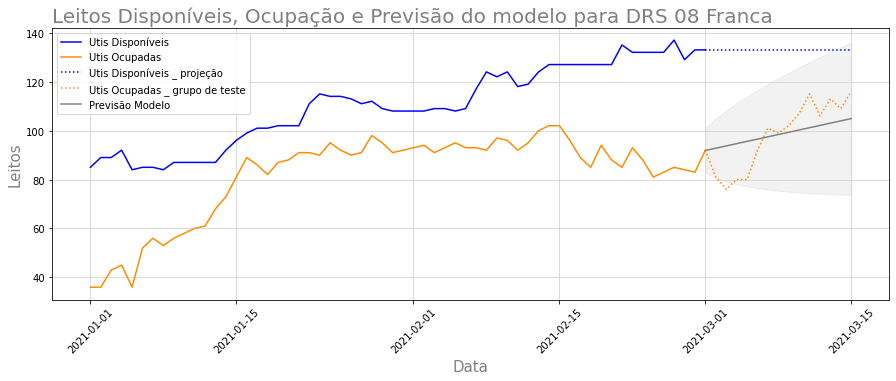

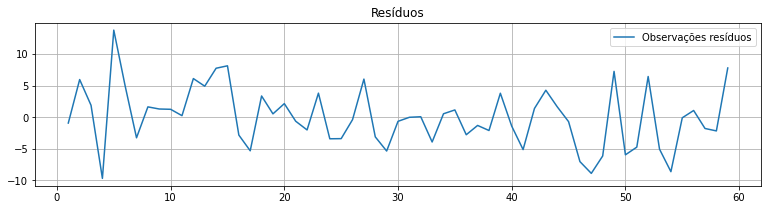

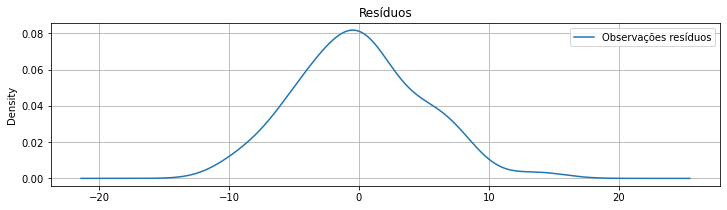

###### Estatística descritiva dos Resíduos ############
       Observações resíduos
count             59.000000
mean              -0.000249
std                4.740460
min               -9.677377
25%               -3.189162
50%               -0.100127
75%                2.743492
max               13.756179
Teste de Shapiro para validação de Normalidade dos Resíduos 
stat=0.986 , p=0.732

Resíduos passaram no teste de Normalidade


In [27]:
 ######### Inputs de Data Set ################

df = leitos_internacao
filtro = df.nome_drs[12]
coluna_filtrada = 'nome_drs'

print(filtro)

##### Inputs de datas do Modelo #############

coluna_data = 'datahora' #coluna no data set que contem a data

data_inicio_treino = ' 2021-01-01' #Data de início de treino do modelo
data_fim_treino = '2021-03-01' #data de Fim de treino do modelo
data_fim_previsao = '2021-03-15' #Data de fim de previsão

q_desloq=1


previsaov01 (df, filtro, coluna_filtrada,data_inicio_treino, data_fim_treino,data_fim_previsao,q_desloq)